In [1]:
import pygame
import os
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from PIL import Image
import random
import matplotlib.pyplot as plt
from matplotlib import animation
from collections import deque
import gc
import psutil

pygame 2.6.1 (SDL 2.28.4, Python 3.9.15)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
print(torch.cuda.is_available())  # 應該為 True
print(torch.version.cuda)         # 應該列出 CUDA 版本
print(torch.backends.cudnn.version())  # cuDNN 版本
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

True
12.1
90100


In [3]:
script_dir = os.path.join(os.getcwd(), 'space_ship_game_RL')
if script_dir not in sys.path:
    sys.path.append(script_dir)

from setting import *
from game import Game


In [4]:
class SpaceShipEnv():
    def __init__(self):
        pygame.init()
        pygame.font.init()

        # 延後畫面初始化，等 render() 時才設置
        self.screen = None
        self.clock = pygame.time.Clock()
        self.fps = FPS

        self.game = Game()

        self.action_space = [0, 1, 2, 3]
        self.observation = self.get_state()

    def step(self, action):
        self.game.update(action)
    
        if self.screen is None:
            self.game.draw()
        else:
            self.game.draw(self.screen)
            self.clock.tick(self.fps)
    
        img_state, structured_state = self.get_state()
        state_info = self.game.get_state_info()
    
        # Components
        reward_components = {}
    
        reward_components['base'] = 0  # no base survival penalty
    
        danger_zones = state_info["danger_zones"]  # list of 0/1 flags per zone, length 8
        player_speed = abs(self.game.player.sprite.speedx)
        rock_density = state_info.get("rock_density", 0)
        player_x = self.game.player.sprite.rect.centerx
    
        zone_id = int(state_info["zone_id"])
        is_in_danger_zone = zone_id in [i for i, danger in enumerate(danger_zones) if danger]
    
        # Safe zone bonus
        reward_components['safe_zone_bonus'] = 0.3 if not is_in_danger_zone else 0.0
    
        # Penalty for being in dangerous zones (soft-capped)
        raw_penalty = -0.01 * sum(danger_zones)
        reward_components['danger_zone_penalty'] = max(raw_penalty, -1.0)
    
        # Movement encouragement
        if sum(danger_zones) > 0 and player_speed > 0.5:
            reward_components['movement_bonus'] = 0.05
        elif sum(danger_zones) == 0 and player_speed < 0.1:
            reward_components['movement_penalty'] = -0.1
        else:
            reward_components['movement_bonus'] = 0.0
            reward_components['movement_penalty'] = 0.0
    
        # Penalize crowded areas
        reward_components['rock_density_penalty'] = -0.3 if rock_density > 3 else 0.0
    
        # Edge penalty
        reward_components['edge_penalty'] = -0.1 if (player_x < WIDTH * 0.1 or player_x > WIDTH * 0.9) else 0.0
    
        # Last-minute dodging bonus
        if hasattr(self, 'last_zone_danger') and self.last_zone_danger and not is_in_danger_zone:
            reward_components['dodging_bonus'] = 1.0
        else:
            reward_components['dodging_bonus'] = 0.0
        self.last_zone_danger = is_in_danger_zone
    
        # Game events
        reward_components['hit_rock_bonus'] = 3.0 if self.game.is_hit_rock else 0.0
        reward_components['collision_penalty'] = -20 if self.game.is_collided else 0.0
        reward_components['power_bonus'] = 10 if self.game.is_power else 0.0
    
        # Power alignment bonus
        power_alignment = any(
            abs(power.rect.centerx - player_x) < 40 and
            power.rect.bottom > self.game.player.sprite.rect.top - 100
            for power in self.game.powers
        )
        reward_components['power_alignment_bonus'] = 0.3 if power_alignment else 0.0
    
        # Score gain bonus
        current_score = self.game.score
        score_gain = current_score - self.last_score
        self.last_score = current_score
        reward_components['score_bonus'] = score_gain * 0.5  # adjust scale as needed
    
        # Total reward
        reward = sum(reward_components.values())
    
        next_state = (img_state, structured_state)
        done = not self.game.running or self.game.score >= 10000
        info = self.game.score
    
        return next_state, reward, done, info, reward_components
        
    def reset(self):
        self.game = Game()
        self.last_score = 0
        return self.get_state()

    def render(self):
        if self.screen is None:
            self.screen = pygame.display.set_mode((WIDTH, HEIGHT))
            pygame.display.set_caption("SpaceShip RL Environment")

    def close(self):
        pygame.quit()

    def get_state(self):
        raw_frame = self.game.state  # shape: (WIDTH, HEIGHT, 3)
        frame = preprocess_frame(raw_frame.swapaxes(0, 1).astype(np.uint8))  # now shape (H, W, 3)
        
        if not hasattr(self, 'stacked_frames'):
            self.stacked_frames = deque([frame]*4, maxlen=4)
        else:
            self.stacked_frames.append(frame)
    
        stacked_image = np.stack(self.stacked_frames, axis=0)  # shape: (4, 84, 84)
    
        # === Structured Features ===
        player = self.game.player.sprite
        player_x = player.rect.centerx
        player_speed = player.speedx
        player_zone_id = int(player_x / (WIDTH / 8))
    
        # --- Danger zones ---
        danger_zones = [0] * 8
        for rock in self.game.rocks:
            if rock.rect.bottom > player.rect.top - 80:  # near the player vertically
                zone = int(rock.rect.centerx / (WIDTH / 8))
                danger_zones[min(zone, 7)] = 1
    
        # --- Rock density near player ---
        rock_density = sum(
            1 for rock in self.game.rocks 
            if abs(rock.rect.centery - player.rect.centery) < 150
        )
    
        # --- Alignment with falling power ---
        power_zone = 0
        for power in self.game.powers:
            if power.rect.bottom > player.rect.top - 100:
                if abs(power.rect.centerx - player_x) < 40:
                    power_zone = 1
                    break
    
        # --- Edge proximity flag ---
        is_near_edge = 1 if (player_x < WIDTH * 0.1 or player_x > WIDTH * 0.9) else 0
    
        # --- Last frame zone danger flag ---
        last_zone_danger = 0
        if hasattr(self, 'last_zone_danger_flag'):
            last_zone_danger = int(self.last_zone_danger_flag)
    
        # Save current danger status for next step
        self.last_zone_danger_flag = danger_zones[player_zone_id] == 1
    
        # --- Construct final structured state ---
        structured_state = np.array(
            danger_zones +                                 # 8
            [player_speed / 10.0,                          # 1 (normalized speed)
             rock_density / 10.0,                          # 1 (normalized density)
             power_zone,                                   # 1 (under power drop)
             player_zone_id / 7.0,                         # 1 (zone ID normalized to 0~1)
             is_near_edge,                                 # 1 (edge danger flag)
             last_zone_danger],                            # 1 (prior zone danger)
            dtype=np.float32
        )
    
        return stacked_image, structured_state


In [5]:
# Hyperparameters
num_episodes = 4000
batch_size = 64
gamma = 0.99
lr = 1e-4
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.999
memory_capacity = 60000  # 100000
target_update_freq = 2000   # 1000

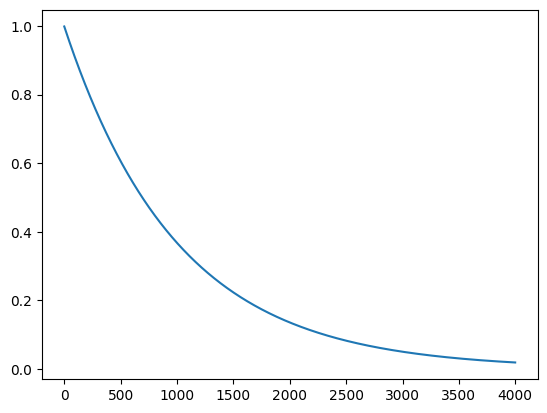

In [6]:
epsilon_list=[]
epsilon=epsilon_start
for i in range(num_episodes):
    epsilon = max(epsilon_end, epsilon * epsilon_decay)
    epsilon_list.append(epsilon)
plt.plot(epsilon_list)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [8]:
# CNN-based DQN Model
class DQN(nn.Module):
    def __init__(self, num_actions, structured_dim=14):
        super(DQN, self).__init__()

        # === CNN part for image input ===
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)  # (4, 84, 84) → (32, 20, 20)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2) # (64, 9, 9)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1) # (64, 7, 7)
        self.flattened_size = 64 * 7 * 7

        self.image_fc = nn.Linear(self.flattened_size, 512)

        # === MLP for structured input ===
        self.structured_fc = nn.Sequential(
            nn.Linear(structured_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64)
        )

        # === Final layers ===
        self.combined_fc = nn.Sequential(
            nn.Linear(512 + 64, 256),
            nn.ReLU(),
            nn.Linear(256, num_actions)
        )

    def forward(self, x_img, x_struct):
        # x_img: (B, 4, 84, 84)
        x = F.relu(self.conv1(x_img))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.image_fc(x))  # shape: (B, 512)

        s = self.structured_fc(x_struct)  # shape: (B, 64)

        combined = torch.cat((x, s), dim=1)  # (B, 512 + 64)
        return self.combined_fc(combined)


In [9]:
# Replay buffer
# 用於儲存代理人經驗（狀態、動作、獎勵等）的緩衝區，支援隨機抽樣以打破時間相關性，有助於穩定訓練。

class ReplayMemory:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        # Use deque with a fixed capacity to automatically discard the oldest experience when full.
        # 使用 deque 並設定最大長度，當容量滿時會自動移除最舊的資料。

    def push(self, img, struct, action, reward, next_img, next_struct, done):
        self.buffer.append((img, struct, action, reward, next_img, next_struct, done))
        # Store a single transition (experience) in the buffer.
        # 儲存一筆經驗（狀態轉移）進緩衝區。

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        # Randomly sample a batch of transitions to break correlation between consecutive samples.
        # 隨機抽取一批經驗，打破樣本間的時間關聯性，提高訓練穩定性。

        # Unpack each element into separate tensors for network input
        # 將 batch 拆解成分別的 tensor 以供神經網路訓練
        imgs, structs, actions, rewards, next_imgs, next_structs, dones = zip(*batch)
        
        # Convert the sampled data into tensors and move them to the specified device (CPU or GPU)
        # 將抽樣資料轉成 tensor 並移至指定設備（CPU/GPU）
        imgs = torch.tensor(np.stack(imgs), dtype=torch.float32, device=device)
        structs = torch.tensor(np.stack(structs), dtype=torch.float32, device=device)
        actions = torch.tensor(actions, dtype=torch.int64, device=device)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=device)
        next_imgs = torch.tensor(np.stack(next_imgs), dtype=torch.float32, device=device)
        next_structs = torch.tensor(np.stack(next_structs), dtype=torch.float32, device=device)
        dones = torch.tensor(dones, dtype=torch.float32, device=device)
        
        return imgs, structs, actions, rewards, next_imgs, next_structs, dones

    def __len__(self):
        return len(self.buffer)
        # Return the current size of the buffer.
        # 回傳緩衝區目前儲存的資料數量。


In [10]:
# Preprocess frames (grayscale and resize to 84x84)
# 預處理影格：轉為灰階並縮放為 84x84

def preprocess_frame(frame):
    # frame: (H, W, 3), dtype should be uint8
    if frame.shape[-1] != 3 or frame.dtype != np.uint8:
        raise ValueError(f"Invalid frame shape or dtype: {frame.shape}, {frame.dtype}")
    # frame 是 numpy array (H, W, 3)，先轉為 PIL Image
    # Input is a color image (RGB), convert to PIL format for easier processing.
    # 輸入是彩色圖像（RGB），轉成 PIL Image 以方便處理。
    image = Image.fromarray(frame)

    # 轉灰階
    # Convert the image to grayscale to reduce input complexity.
    # 將影像轉為灰階，降低輸入維度與計算量。
    image = image.convert('L')

    # resize 成 84x84
    # Resize the image to a standard 84x84 shape, as per DQN convention.
    # 依照 DQN 的慣例將影像統一縮放至 84x84。
    image = image.resize((84, 84), Image.Resampling.BILINEAR)  # or NEAREST, or LANCZOS

    # 轉回 numpy 並正規化
    # Convert back to NumPy and normalize pixel values to [0, 1].
    # 轉回 NumPy 格式並將像素值標準化到 [0, 1]。
    frame = np.asarray(image, dtype=np.float32) / 255.0

    return frame


# def stack_frames(stacked_frames, state, is_new_episode):
#     # 預處理目前影格
#     frame = preprocess_frame(state)

#     if is_new_episode or stacked_frames is None:
#         # If it's a new episode or no previous frames, initialize with 4 identical frames
#         # 若是新的一集或是尚未初始化，則用目前影格複製 4 次形成初始堆疊
#         stacked_frames = deque([frame]*4, maxlen=4)
#     else:
#         # 否則把新影格加入到堆疊中，自動捨棄最舊的
#         stacked_frames.append(frame)

#     # Stack the 4 frames along the first dimension: shape becomes (4, 84, 84)
#     # 沿著第一維（channel）堆疊成 4 通道輸入：形狀變成 (4, 84, 84)
#     stacked_state = np.stack(stacked_frames, axis=0)

#     return stacked_state, stacked_frames


In [11]:
end_episode = 4000
debug_mode = False

In [12]:
# 初始化 Breakout 環境 / Initialize the Breakout environment
env = SpaceShipEnv()
num_actions = len(env.action_space)

# 建立策略網路與目標網路 / Create policy and target networks
# Get one sample state to infer the dimension of the structured input
sample_state = env.reset()  # (img_stack, structured_state)
structured_dim = len(sample_state[1])
# print(f"Auto-detected structured_dim: {structured_dim}")

policy_net = DQN(num_actions, structured_dim).to(device)
target_net = DQN(num_actions, structured_dim).to(device)
target_net.load_state_dict(policy_net.state_dict())  # 初始時讓目標網路等於策略網路
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=lr)
memory = ReplayMemory(memory_capacity)

# 載入模型（若有）
if os.path.exists('checkpoint.pth'):
    checkpoint = torch.load('checkpoint.pth', map_location=device)
    policy_net.load_state_dict(checkpoint['policy_net'])
    target_net.load_state_dict(checkpoint['target_net'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    start_episode = checkpoint['episode'] + 1
    total_steps = checkpoint['total_steps']
    best_score = checkpoint['best_score']
    epsilon = checkpoint['epsilon']
    reward_history = checkpoint['reward_history']
    score_history = checkpoint['score_history']
    steps_per_episode = checkpoint.get('steps_per_episode', [])
    loss_history = checkpoint.get('loss_history', [])
    q_value_means = checkpoint.get('q_value_means', [])
    q_value_maxs = checkpoint.get('q_value_maxs', [])
    q_value_mins = checkpoint.get('q_value_mins', [])
    print(f"Loaded checkpoint from episode {start_episode}, best score: {best_score:.2f}, epsilon={epsilon:.3f}")
else:
    start_episode = 0
    total_steps = 0
    best_score = float('-inf')
    epsilon = epsilon_start
    reward_history = []
    score_history = []
    steps_per_episode = []
    loss_history = []
    q_value_means, q_value_maxs, q_value_mins = [], [], []


# 訓練迴圈 / Training loop
# 每次可以訓練個100步(根據自己的設備與時間調整)，然後下一次都再接續上次的訓練模型接續往下訓練
# You can train for 100 steps each time (adjust according to your own equipment and time), 
# and then continue training from the last training model next time.
for episode in range(start_episode, end_episode):  # You can increase this for longer training
    try:
        raw_state = env.reset()
        state = raw_state  # raw_state 已經是 (stacked_image, structured_state)
    
        total_reward, done = 0, False
        reward_component_sums = {key: 0.0 for key in [
            'base', 'safe_zone_bonus', 'danger_zone_penalty', 'movement_bonus', 'movement_penalty',
            'rock_density_penalty', 'edge_penalty', 'dodging_bonus',
            'hit_rock_bonus', 'collision_penalty', 'power_bonus', 'power_alignment_bonus',
            'score_bonus'
        ]}
        steps_this_episode = 0
        episode_loss = 0
        loss_count = 0
        q_values_this_episode = []
        
        while not done:
            if random.random() < epsilon:
                action = random.choice(env.action_space)
            else:
                with torch.no_grad():
                    img_tensor = torch.tensor(state[0], dtype=torch.float32, device=device).unsqueeze(0)
                    struct_tensor = torch.tensor(state[1], dtype=torch.float32, device=device).unsqueeze(0)
    
                    # Input shape sanity check
                    if episode == 0 and total_steps == 0:
                        print("img_tensor shape:", img_tensor.shape)        # (1, 4, 84, 84)
                        print("struct_tensor shape:", struct_tensor.shape)  # (1, 10)
                        
                    q_values = policy_net(img_tensor, struct_tensor)
                    action = q_values.argmax(dim=1).item()
    
            next_state, reward, done_, score, reward_components = env.step(action)
    
            # Accumulate reward components
            for key, val in reward_components.items():
                reward_component_sums[key] += val
    
            memory.push(state[0], state[1], action, reward, next_state[0], next_state[1], done_)
            state = next_state
            done = done_
            total_reward += reward
            steps_this_episode += 1
    
            # Train the model
            if len(memory) >= batch_size:
                imgs, structs, actions, rewards, next_imgs, next_structs, dones = memory.sample(batch_size)
    
                with torch.no_grad():
                    target_q = rewards + gamma * target_net(next_imgs, next_structs).max(1)[0] * (1 - dones)
                    q_stats = policy_net(imgs, structs)
                    q_values_this_episode.append((
                        q_stats.mean().item(),
                        q_stats.max().item(),
                        q_stats.min().item()
                    ))
                    
                current_q = policy_net(imgs, structs).gather(1, actions.unsqueeze(1)).squeeze(1)
                loss = F.mse_loss(current_q, target_q)
    
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                episode_loss += loss.item()
                loss_count += 1
    
            total_steps += 1
            if total_steps % target_update_freq == 0:
                target_net.load_state_dict(policy_net.state_dict())
    
        # Epsilon decay
        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        reward_history.append(total_reward)
        score_history.append(score)
    
        avg_loss = episode_loss / loss_count if loss_count > 0 else 0.0
        loss_history.append(avg_loss)
        if q_values_this_episode:
            means, maxs, mins = zip(*q_values_this_episode)
            q_value_means.append(np.mean(means))
            q_value_maxs.append(np.mean(maxs))
            q_value_mins.append(np.mean(mins))
        steps_per_episode.append(steps_this_episode)
        print(f"Episode {episode + 1:3d}, Reward: {total_reward:7.2f}, Score: {score:4d}, Avg Loss: {avg_loss:.4f}, Epsilon: {epsilon:5.3f}")
        if debug_mode or (episode + 1) % 100 == 0:
            print("Reward Breakdown:", ", ".join(f"{key}: {val:.2f}" for key, val in reward_component_sums.items()))

         # Periodic memory cleanup
        gc.collect()
        torch.cuda.empty_cache()

        # Periodic memory usage logging
        if (episode + 1) % 50 == 0:
            mem = psutil.virtual_memory()
            print(f"[MEM] RAM Used: {mem.percent:.1f}%, Available: {mem.available // (1024**2)}MB")
            
        # Save model
        if (episode + 1) % 50 == 0 or score > best_score:
            best_score = max(best_score, score)
            torch.save({
                'policy_net': policy_net.state_dict(),
                'target_net': target_net.state_dict(),
                'optimizer': optimizer.state_dict(),
                'epsilon': epsilon,
                'episode': episode,
                'total_steps': total_steps,
                'best_score': best_score,
                'reward_history': reward_history,
                'score_history': score_history,
                'steps_per_episode': steps_per_episode,
                'loss_history': loss_history,
                'q_value_means': q_value_means,
                'q_value_maxs': q_value_maxs,
                'q_value_mins': q_value_mins,
            }, 'checkpoint.pth')
            print(f"Checkpoint saved at episode {episode + 1}, best score: {best_score:.2f}")
    except Exception as e:
        print(f"Error at episode {episode}: {str(e)}")
        torch.save({
            'policy_net': policy_net.state_dict(),
            'target_net': target_net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epsilon': epsilon,
            'episode': episode,
            'total_steps': total_steps,
            'best_score': best_score,
            'reward_history': reward_history,
            'score_history': score_history,
            'steps_per_episode': steps_per_episode,
            'loss_history': loss_history,
            'q_value_means': q_value_means,
            'q_value_maxs': q_value_maxs,
            'q_value_mins': q_value_mins,
        }, 'crash_checkpoint.pth')
        break  # or continue
env.close()


C:\Users\johns\AppData\Local\Temp\ipykernel_12792\487218897.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoint.pth', map_location=devic

Loaded checkpoint from episode 3550, best score: 2108.00, epsilon=0.029
Episode 3551, Reward:   59.69, Score:  470, Avg Loss: 2.2948, Epsilon: 0.029
Episode 3552, Reward:  162.64, Score:  736, Avg Loss: 1.9019, Epsilon: 0.029
Episode 3553, Reward:  427.02, Score: 1096, Avg Loss: 3.0197, Epsilon: 0.029
Episode 3554, Reward:  -74.67, Score:   88, Avg Loss: 1.8524, Epsilon: 0.029
Episode 3555, Reward:  126.12, Score:  546, Avg Loss: 3.5728, Epsilon: 0.029
Episode 3556, Reward:   67.57, Score:  382, Avg Loss: 2.2382, Epsilon: 0.029
Episode 3557, Reward:   52.02, Score:  460, Avg Loss: 3.9470, Epsilon: 0.028
Episode 3558, Reward:   57.47, Score:  306, Avg Loss: 2.5123, Epsilon: 0.028
Episode 3559, Reward:   90.01, Score:  398, Avg Loss: 3.1638, Epsilon: 0.028
Episode 3560, Reward:  -13.74, Score:  316, Avg Loss: 3.3329, Epsilon: 0.028
Episode 3561, Reward:   54.74, Score:  372, Avg Loss: 2.8180, Epsilon: 0.028
Episode 3562, Reward:    7.87, Score:  280, Avg Loss: 3.3238, Epsilon: 0.028
Epis

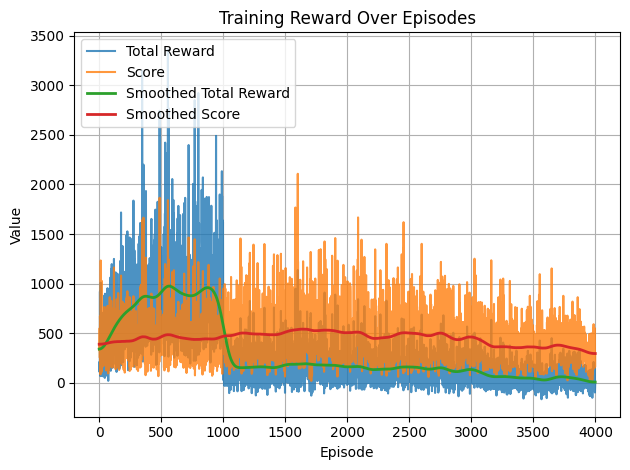

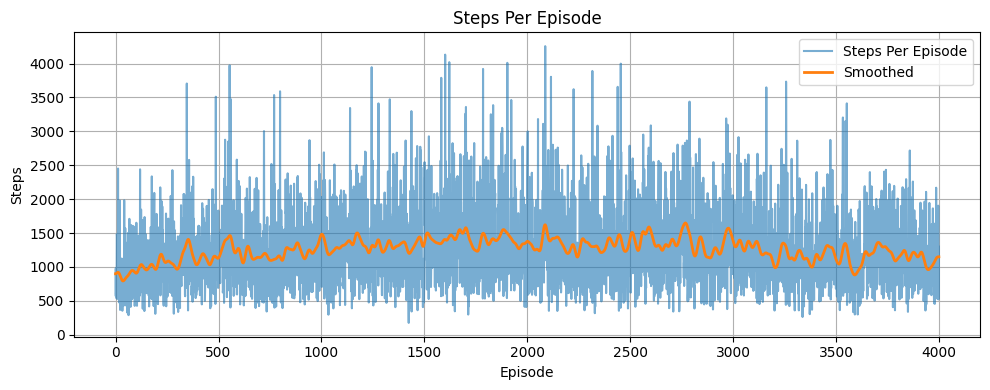

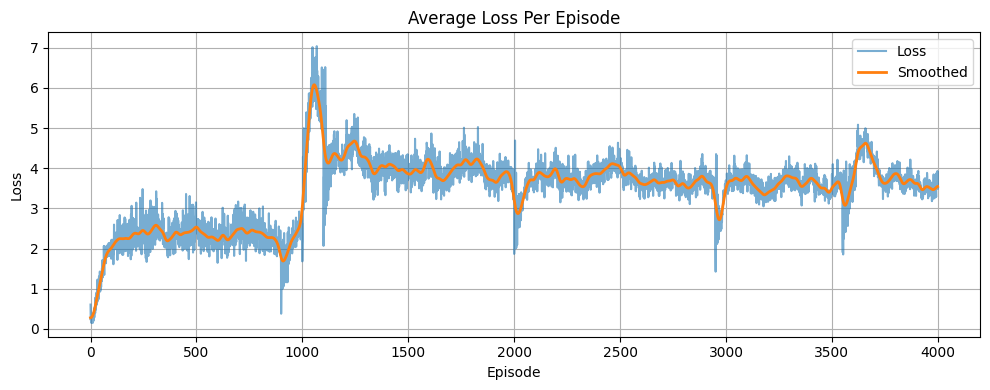

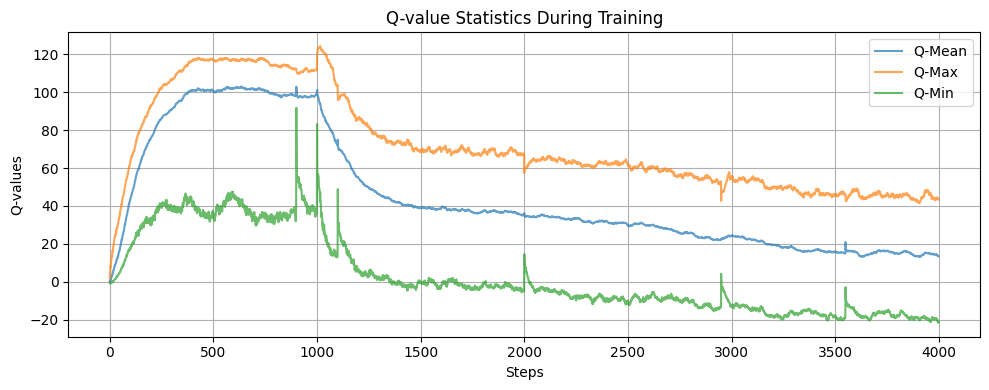

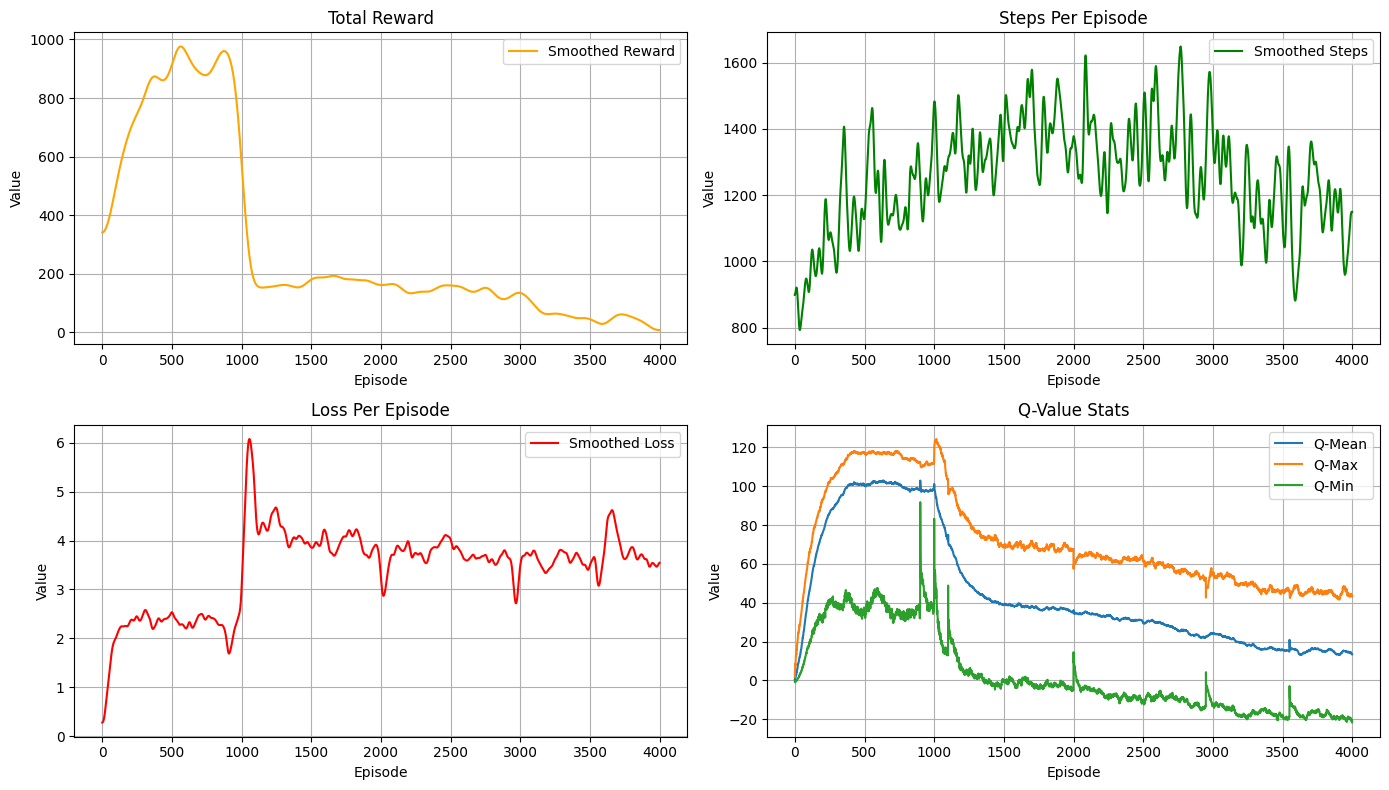

In [13]:
from scipy.ndimage import gaussian_filter1d

reward_smooth = gaussian_filter1d(reward_history, sigma=50)
score_smooth = gaussian_filter1d(score_history, sigma=50)

# 畫圖
# plt.figure(figsize=(10, 5))
plt.plot(reward_history, label='Total Reward', alpha=0.8)
plt.plot(score_history, label='Score', alpha=0.8)
plt.plot(reward_smooth, label='Smoothed Total Reward', linewidth=2)
plt.plot(score_smooth, label='Smoothed Score', linewidth=2)

plt.legend(loc='upper left')
plt.xlabel("Episode")
plt.ylabel("Value")
plt.title("Training Reward Over Episodes")
plt.grid(True)
plt.tight_layout()
# plt.savefig("dqn_training_curve.png")

# --- Plot: Smoothed Steps Per Episode ---
if 'steps_per_episode' in globals():
    plt.figure(figsize=(10, 4))
    steps_smooth = gaussian_filter1d(steps_per_episode, sigma=10)
    plt.plot(steps_per_episode, label='Steps Per Episode', alpha=0.6)
    plt.plot(steps_smooth, label='Smoothed', linewidth=2)
    plt.xlabel("Episode")
    plt.ylabel("Steps")
    plt.title("Steps Per Episode")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Plot: Training Loss ---
if 'loss_history' in globals() and loss_history:
    plt.figure(figsize=(10, 4))
    loss_smooth = gaussian_filter1d(loss_history, sigma=10)
    plt.plot(loss_history, label='Loss', alpha=0.6)
    plt.plot(loss_smooth, label='Smoothed', linewidth=2)
    plt.xlabel("Episode")
    plt.ylabel("Loss")
    plt.title("Average Loss Per Episode")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Plot: Q-value statistics ---
if 'q_value_means' in globals():
    plt.figure(figsize=(10, 4))
    plt.plot(q_value_means, label='Q-Mean', alpha=0.7)
    plt.plot(q_value_maxs, label='Q-Max', alpha=0.7)
    plt.plot(q_value_mins, label='Q-Min', alpha=0.7)
    plt.xlabel("Steps")
    plt.ylabel("Q-values")
    plt.title("Q-value Statistics During Training")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Summary Grid View (optional) ---
# Show all 4 in a single window for side-by-side comparison
# Uncomment below if you prefer 2x2 grid visualization

fig, axs = plt.subplots(2, 2, figsize=(14, 8))

axs[0, 0].plot(reward_smooth, label="Smoothed Reward", color='orange')
axs[0, 0].set_title("Total Reward")
axs[0, 0].grid(True)

axs[0, 1].plot(steps_smooth, label="Smoothed Steps", color='green')
axs[0, 1].set_title("Steps Per Episode")
axs[0, 1].grid(True)

axs[1, 0].plot(loss_smooth, label="Smoothed Loss", color='red')
axs[1, 0].set_title("Loss Per Episode")
axs[1, 0].grid(True)

axs[1, 1].plot(q_value_means, label='Q-Mean')
axs[1, 1].plot(q_value_maxs, label='Q-Max')
axs[1, 1].plot(q_value_mins, label='Q-Min')
axs[1, 1].set_title("Q-Value Stats")
axs[1, 1].grid(True)

for ax in axs.flat:
    ax.legend()
    ax.set_xlabel("Episode")
    ax.set_ylabel("Value")

plt.tight_layout()
plt.show()
